##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [356]:
#%pip install pandas 
#%pip install matplotlib
#%pip install warnings
#%pip install numpy
#%pip install seaborn
#%pip install matplotlib.pyplot
#%pip install scikit-learn
#%pip install imbalanced-learn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [357]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [358]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Reading in Data
- For all of the steps below, I did my testing and printing of information in a separate notebook. Below, the code is condensed to just the actual steps I took plus some relevant comments.

In [359]:
df = pd.read_parquet(filepath)
df

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_

# Data Preprocessing Steps

## Fixing Target Column -> replace NANs with 0s, as they are not purchases

<AxesSubplot:>

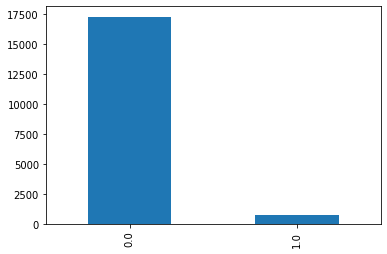

In [360]:
df['f_purchase_lh'].fillna(0, inplace=True)
df['f_purchase_lh'].value_counts().plot(kind='bar')

## Merging Columns that share prefixes
- Big assumption I'm making is that I can just take the mean of multiple columns that have a prefix, like 'ape_' -> I am mainly doing this to simplify the dataset and to reduce the number of columns without just blindly removing them. I am not too sure if this is the best way to approach this, but given I don't have enough domain knowledge to make a better decision, I will make this assumption for now and see if it makes sense later on

In [361]:
merge_prefixes = ['ape_', 'sumins_', 'prempaid_', 'f_hold_', 'lapse_ape_', 'n_months_since_lapse_', 'f_ever_bought_', 'n_months_last_bought_', 'f_ever_bought_', 'flg_hlthclaim_', 'recency_hlthclaim_']

for prefix in merge_prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    df[prefix + 'mean'] = df[cols].mean(axis=1)
    df.drop(cols, axis=1, inplace=True)

## Strategies to Deal with Missing Data 

1. Remove columns with 100% missing values

2. First check which columns have a lot of missing values (more than 50%)
    - First check what the column represents and if it isn't useful for our analysis, drop or merge the column appropriately
        - Ex: 'f_ever_declined_la' can be made into a binary column, 1 if declined, 0 if not while a column like 'lapse_ape_...' can be merged with the other 'lapse_ape_...' columns
    - Big assumption that I'm making for many of these columns is that if the value is NAN, then the value is 0 -> My thought process is that I will make this assumption now and I will later see through metrics like correlation if it makes sense to keep using these columns or not. This is better than me just blindly dropping columns that have a lot of missing values

In [362]:
#Step 1 -> Remove columns with 100% missing values
threshold = 1
for col in df.columns:
    if df[col].isnull().sum() >= threshold*len(df):
        df.drop(col, axis=1, inplace=True)

# Step 2
threshold = 0.5
for col in df.columns:
    if df[col].isnull().sum() > threshold*len(df):
        continue #comment this line if you want prints
        print(col, df[col].isnull().sum()/len(df) * 100)
        print(df[col].nunique())
        if df[col].nunique() < 50:
            print(df[col].unique())
        print('', '\n')

# Deal with seemingly useful columns 1-by-1
df['f_ever_declined_la'].fillna(0, inplace=True)
df['recency_lapse'].fillna(0, inplace=True)
df['recency_cancel'].fillna(0, inplace=True)
df['tot_cancel_pols'].fillna(0, inplace=True)
df['flg_affconnect_show_interest_ever'].fillna(0, inplace=True)
df['flg_affconnect_ready_to_buy_ever'].fillna(0, inplace=True)
df['flg_hlthclaim_mean'].fillna(0, inplace=True)

# Now removing all columns with 50% missing values
threshold = 0.5
for col in df.columns:
    if df[col].isnull().sum() >= threshold*len(df):
        df.drop(col, axis=1, inplace=True)

## Now Dealing with the rest of the columns that have a low amount of missing values

1. One set of rows (that made up around 5-6% of the dataset) had missing values for many of these columns. Another set of rows (that made up around 13-14% of the dataset after removing the first set of rows) also had missing values for many of these columns. I simply removed them
    - I made sure to check the 'f_purchase_lh' values for these rows before removing and only 10 of the 1014 rows were purchases (for the first set of rows) and 19 of the 2809 rows were purchases (for the second set of rows), so I'm not losing too much useful information by removing these rows.


2. This leaves 3 final columns: 'race_desc', 'ctrycode_desc' and 'cltsex_fix' -> For all 3 columns, the 'f_purchase_lh' values were overwhelmingly 0s, so I decided to remove all rows with missing values for these columns, as not much useful information was being lost and it's hard to determine which category to put these rows in without further domain knowledge

In [363]:
# Step 1 -> removing rows that share NANs across many columns
df = df[df['flg_substandard'].notna()]
df = df[df['hh_20'].notna()]

for col in df.columns:
    if df[col].isnull().sum() > 0:
        continue #comment this line if you want prints
        print(col, df[col].isnull().sum())
        print(df[col].nunique())
        if df[col].nunique() < 50:
            print(df[col].unique())
        print('', '\n')

# Step 2
df = df[df['race_desc'].notna()]
df = df[df['ctrycode_desc'].notna()]
df = df[df['cltsex_fix'].notna()]

## Encoding / Type Conversion / Feature Engineering

Going through each of the columns and applying one of the above as necessary. Steps taken for each column are summarized below:
- 'race_desc': nominal data, so using one-hot encoding
- 'stat_flag': nominal data, so using one-hot encoding
- 'ctrycode_desc': binary data, so converting to 1s and 0s
- 'cltsex_fix': binary data, so converting to 1s and 0s
- 'annual_income_est': ordinal data, so using ordinal encoding
- 'hh_size_est': changing >4 to 5
- 'clttype': removing as all values are the same
- 'is_dependent_in_at_least_1_policy': removing as all non-NAN values are 0 so unsure if NAN values should be 0 or 1

- 'min_occ_date': converting to datetime object -> find number of days since purchase via finding number of days between min_occ_date and today's date and make this the new column while removing the original column
- 'cltdob_fix': converting to datetime object -> find client's age via finding number of days between cltdob_fix and today's date and make this the new column while removing the original column

In [364]:
# using pd.get_dummies with drop_first=True for nominal categorical variables
df = pd.get_dummies(df, columns=['race_desc', 'stat_flag'], drop_first=True)

# to convert binary and ordinal categorical variables to numeric
df['ctrycode_desc'].replace({'Singapore': 1, 'Not Applicable': 0}, inplace=True)
df['cltsex_fix'].replace({'Male': 1, 'Female': 0}, inplace=True)
df['annual_income_est'].replace({'E.BELOW30K': 0, 'D.30K-60K': 1, 'C.60K-100K': 2, 'B.100K-200K': 3, 'A.ABOVE200K': 4}, inplace=True)
df['hh_size_est'].replace({'>4': 5}, inplace=True)

# removing columns
df.drop('clttype', axis=1, inplace=True)
df.drop('is_dependent_in_at_least_1_policy', axis=1, inplace=True)

#datetime conversion -> get number of days since purchase
df['min_occ_date'] = pd.to_datetime(df['min_occ_date'])
df['min_occ_date'] = (pd.to_datetime('today') - df['min_occ_date']).dt.days

#datetime conversion -> get age of client
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'])
df['cltdob_fix'] = (pd.to_datetime('today') - df['cltdob_fix']).dt.days
df['cltdob_fix'] = df['cltdob_fix']//365

#type conversion -> converting from object to float
df['hh_20'] = df['hh_20'].astype(float)
df['pop_20'] = df['pop_20'].astype(float)
df['hh_size_est'] = df['hh_size_est'].astype(float)

# Feature Selection via Correlation
- Removing columns that have a correlation of 0.5 or higher with another column -> We remove the column that has a lower correlation with the target column 'f_purchase_lh'

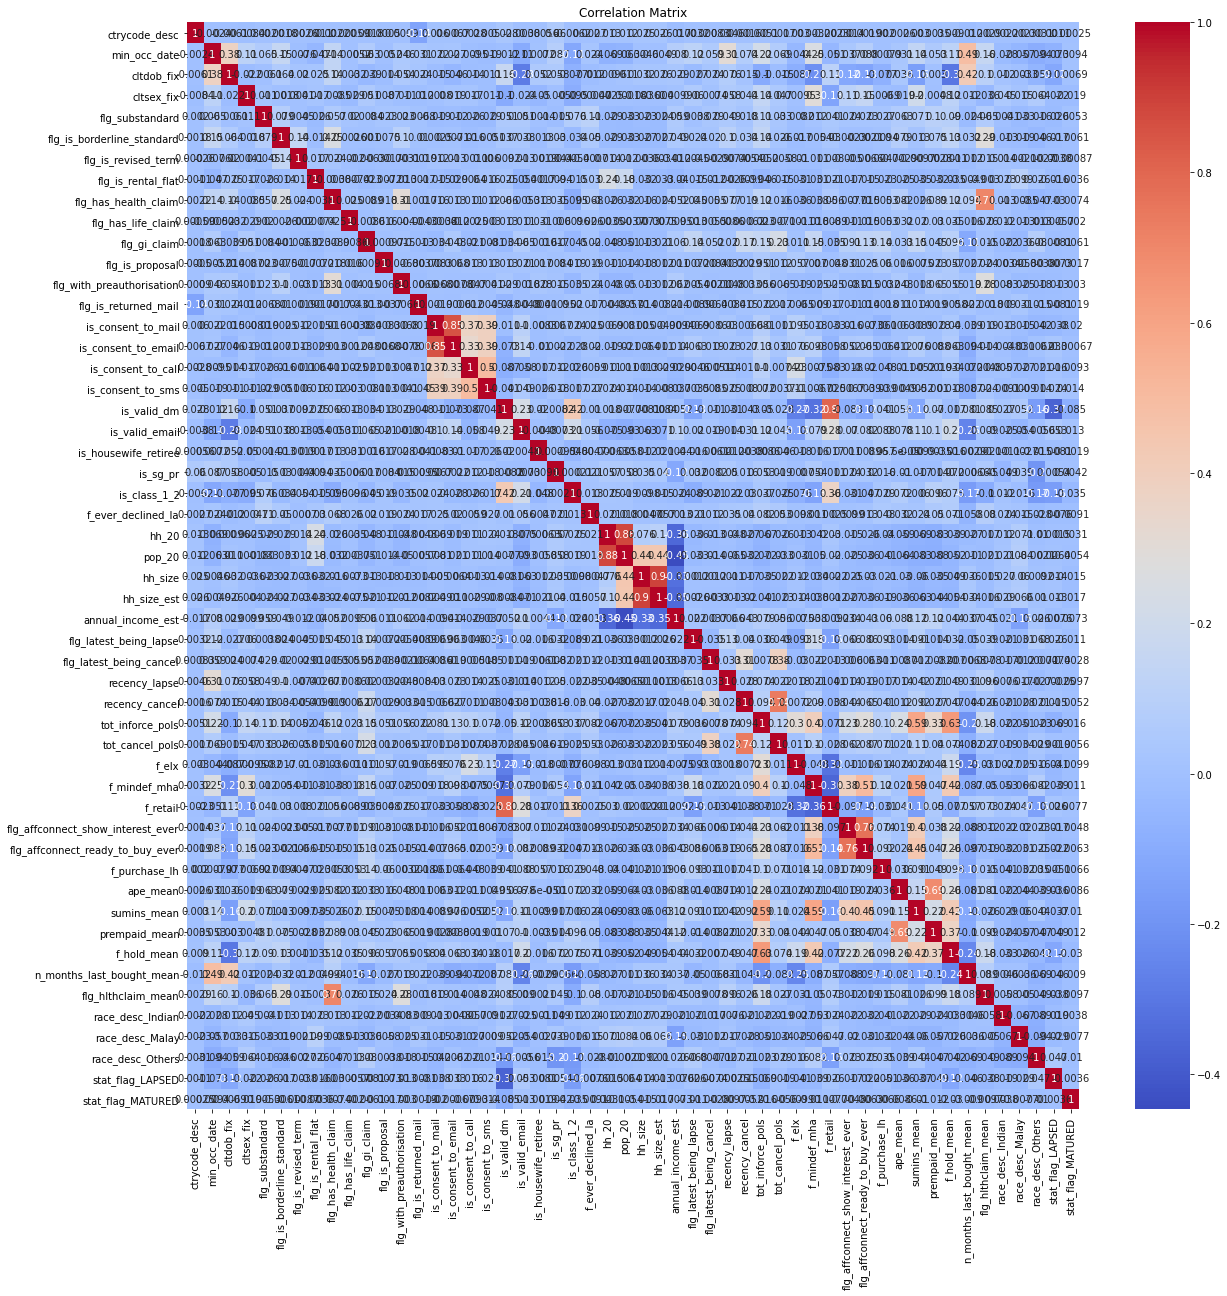

In [365]:
# Correlation Matrix to find highly correlated variables
plt.figure(figsize=(20, 20))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [366]:
# Define a threshold for high correlation
threshold = 0.5
high_corr_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_features.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for feature_pair in high_corr_features:
    correlation_coefficient = "{:.3f}".format(feature_pair[2])
    #print(f"High correlation between '{feature_pair[0]}' and '{feature_pair[1]}: {correlation_coefficient}'")
    #print(f"Correlation between '{feature_pair[0]}' and 'f_purchase_lh': {df['f_purchase_lh'].corr(df[feature_pair[0]])}")
    #print(f"Correlation between '{feature_pair[1]}' and 'f_purchase_lh': {df['f_purchase_lh'].corr(df[feature_pair[1]])}")
    
    #We want to remove the feature that has the lower correlation to the target variable
    try:
        if abs(df['f_purchase_lh'].corr(df[feature_pair[0]])) < abs(df['f_purchase_lh'].corr(df[feature_pair[1]])):
            df.drop(feature_pair[0], axis=1, inplace=True)
        else:
            df.drop(feature_pair[1], axis=1, inplace=True)
    except:
        pass

# Remove further columns using Variance Threshold
- Removing columns that have a variance of 0.05 or lower -> This is to remove columns that have very little variance and thus not useful for analysis

In [367]:
Y = df['f_purchase_lh']
df = df.drop(['clntnum', 'f_purchase_lh'], axis=1)

#Remove features with low variance
threshold = 0.05
var = VarianceThreshold(threshold)
var.fit(df)
low_var_features = [col for col in df.columns if col not in df.columns[var.get_support()]]
for feature in low_var_features:
    print(f"Removing '{feature}' due to low variance")
    df.drop(feature, axis=1, inplace=True)

Removing 'ctrycode_desc' due to low variance
Removing 'flg_substandard' due to low variance
Removing 'flg_is_borderline_standard' due to low variance
Removing 'flg_is_revised_term' due to low variance
Removing 'flg_is_rental_flat' due to low variance
Removing 'flg_has_life_claim' due to low variance
Removing 'flg_gi_claim' due to low variance
Removing 'flg_is_proposal' due to low variance
Removing 'flg_with_preauthorisation' due to low variance
Removing 'flg_is_returned_mail' due to low variance
Removing 'is_housewife_retiree' due to low variance
Removing 'is_sg_pr' due to low variance
Removing 'flg_latest_being_cancel' due to low variance
Removing 'flg_affconnect_show_interest_ever' due to low variance
Removing 'stat_flag_LAPSED' due to low variance
Removing 'stat_flag_MATURED' due to low variance


# Scaling Data
- All columns are now numeric, so we scale everything using StandardScaler

In [368]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Resampling Data
- Now we can finally try to fix the class imabalance issue -> will be using SMOTE to oversample the minority class

In [369]:
#Using SMOTE to deal with imbalanced data
X_train, X_val, y_train, y_val = train_test_split(df, Y, test_size=0.2, random_state=69, stratify=Y)

smote = SMOTE(random_state=69, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

0.0    10023
1.0      522
Name: f_purchase_lh, dtype: int64
0.0    2506
1.0     131
Name: f_purchase_lh, dtype: int64
0.0    10023
1.0    10023
Name: f_purchase_lh, dtype: int64
0.0    2506
1.0     131
Name: f_purchase_lh, dtype: int64


# Modeling

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [370]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [371]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!